In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
# U-Net Model Definition
def build_unet(input_shape=(256, 256, 1)):
    inputs = Input(shape=input_shape)

    # Encoder (Downsampling Path)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)

    # Decoder (Upsampling Path)
    u1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b)
    u1 = concatenate([u1, c2])
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    u2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u2 = concatenate([u2, c1])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    # Output layer for colorization
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c4)  # 3 channels for RGB output

    return Model(inputs, outputs)

# Compile the U-Net model
model = build_unet()
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
# Image Preprocessing (Resizing and Normalization)
def preprocess_images(sar_images, optical_images, img_size=(256, 256)):
    sar_images_resized = [cv2.resize(img, img_size) for img in sar_images]
    optical_images_resized = [cv2.resize(img, img_size) for img in optical_images]

    # Normalizing the images
    sar_images_resized = np.array(sar_images_resized) / 255.0
    optical_images_resized = np.array(optical_images_resized) / 255.0

    # Add channel dimension for grayscale SAR images
    sar_images_resized = sar_images_resized[..., np.newaxis]

    return sar_images_resized, optical_images_resized


In [ ]:

# Example SAR and Optical images (Dummy data)
sar_images = [np.random.rand(512, 512) * 255 for _ in range(100)]
optical_images = [np.random.rand(512, 512, 3) * 255 for _ in range(100)]

# Preprocess the images
sar_images_processed, optical_images_processed = preprocess_images(sar_images, optical_images)

# Split data into training and testing sets
train_size = int(0.8 * len(sar_images_processed))
X_train, X_test = sar_images_processed[:train_size], sar_images_processed[train_size:]
y_train, y_test = optical_images_processed[:train_size], optical_images_processed[train_size:]

# Data Augmentation
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)


Epoch 1/20
5/5 [==============================] - 38s 1s/step - loss: 0.0209 - accuracy: 0.3330 - val_loss: 0.0208 - val_accuracy: 0.3338
Epoch 2/20
5/5 [==============================] - 2s 492ms/step - loss: 0.0208 - accuracy: 0.3332 - val_loss: 0.0208 - val_accuracy: 0.3332
Epoch 3/20
5/5 [==============================] - 2s 510ms/step - loss: 0.0208 - accuracy: 0.3331 - val_loss: 0.0208 - val_accuracy: 0.3334
Epoch 4/20
5/5 [==============================] - 2s 466ms/step - loss: 0.0208 - accuracy: 0.3338 - val_loss: 0.0208 - val_accuracy: 0.3335
Epoch 5/20
5/5 [==============================] - 2s 466ms/step - loss: 0.0208 - accuracy: 0.3337 - val_loss: 0.0208 - val_accuracy: 0.3330
Epoch 6/20
5/5 [==============================] - 2s 469ms/step - loss: 0.0208 - accuracy: 0.3333 - val_loss: 0.0208 - val_accuracy: 0.3338
Epoch 7/20
5/5 [==============================] - 2s 471ms/step - loss: 0.0208 - accuracy: 0.3334 - val_loss: 0.0208 - val_accuracy: 0.3332
Epoch 8/20
5/5 [======

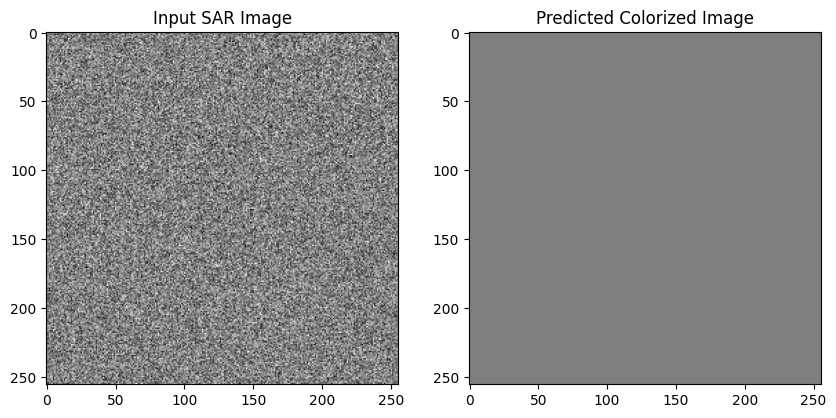

In [ ]:

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Generate a colorized image
predicted_image = model.predict(X_test[:1])[0]
plt.figure(figsize=(10, 5))

# Display SAR Input
plt.subplot(1, 2, 1)
plt.imshow(X_test[0].squeeze(), cmap='gray')
plt.title('Input SAR Image')

# Display Colorized Output
plt.subplot(1, 2, 2)
plt.imshow(predicted_image)
plt.title('Predicted Colorized Image')
plt.show()


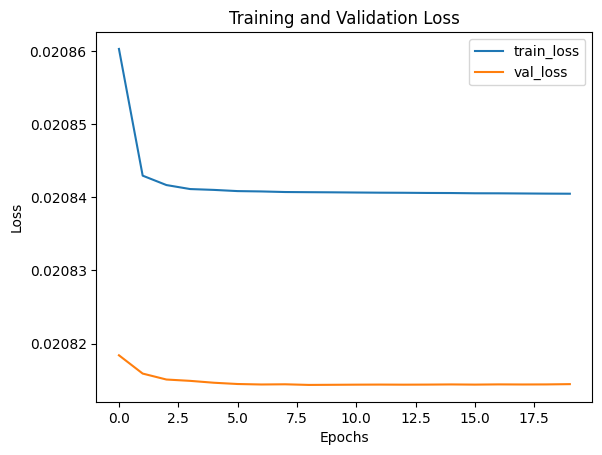

In [ ]:
# Display training vs validation loss curves
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


**Example for SAR Images**

In [ ]:
                                                                                                                                                                            import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt



In [ ]:
# U-Net Model Definition
def build_unet(input_shape=(256, 256, 1)):
    inputs = Input(shape=input_shape)

    # Encoder (Downsampling Path)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)

    # Decoder (Upsampling Path)
    u1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b)
    u1 = concatenate([u1, c2])
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    u2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u2 = concatenate([u2, c1])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    # Output layer for colorization (3 channels for RGB output)
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c4)

    return Model(inputs, outputs)

# Compile the U-Net model
model = build_unet()
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 64)         640       ['input_3[0][0]']             
                                                                                                  
 conv2d_21 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_20[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_21[0][0]']           
 g2D)                                                                                       

In [ ]:
# Image Preprocessing (Resizing and Normalization)
def preprocess_images(sar_images, optical_images, img_size=(256, 256)):
    sar_images_resized = [cv2.resize(img, img_size) for img in sar_images]
    optical_images_resized = [cv2.resize(img, img_size) for img in optical_images]

    # Normalizing the images
    sar_images_resized = np.array(sar_images_resized) / 255.0
    optical_images_resized = np.array(optical_images_resized) / 255.0

    # Add channel dimension for grayscale SAR images
    sar_images_resized = sar_images_resized[..., np.newaxis]

    return sar_images_resized, optical_images_resized


In [ ]:
from PIL import Image
import os

def load_image(image_path, img_size=(512, 512), is_grayscale=False):
    mode = "L" if is_grayscale else "RGB"
    img = Image.open(image_path).convert(mode)
    img = img.resize(img_size)
    return img

# Load single SAR image
sar_image = load_image('/content/drive/MyDrive/data/SAR.png', is_grayscale=True)


Epoch 1/30
1/1 [==============================] - 0s 346ms/step - loss: 0.0260 - accuracy: 0.5556 - val_loss: 0.0260 - val_accuracy: 0.5401
Epoch 2/30
1/1 [==============================] - 0s 278ms/step - loss: 0.0260 - accuracy: 0.5401 - val_loss: 0.0259 - val_accuracy: 0.5511
Epoch 3/30
1/1 [==============================] - 0s 209ms/step - loss: 0.0259 - accuracy: 0.5511 - val_loss: 0.0259 - val_accuracy: 0.5635
Epoch 4/30
1/1 [==============================] - 0s 177ms/step - loss: 0.0259 - accuracy: 0.5635 - val_loss: 0.0258 - val_accuracy: 0.5648
Epoch 5/30
1/1 [==============================] - 0s 185ms/step - loss: 0.0258 - accuracy: 0.5648 - val_loss: 0.0258 - val_accuracy: 0.5573
Epoch 6/30
1/1 [==============================] - 0s 183ms/step - loss: 0.0258 - accuracy: 0.5573 - val_loss: 0.0256 - val_accuracy: 0.5627
Epoch 7/30
1/1 [==============================] - 0s 213ms/step - loss: 0.0256 - accuracy: 0.5627 - val_loss: 0.0257 - val_accuracy: 0.5662
Epoch 8/30
1/1 [====

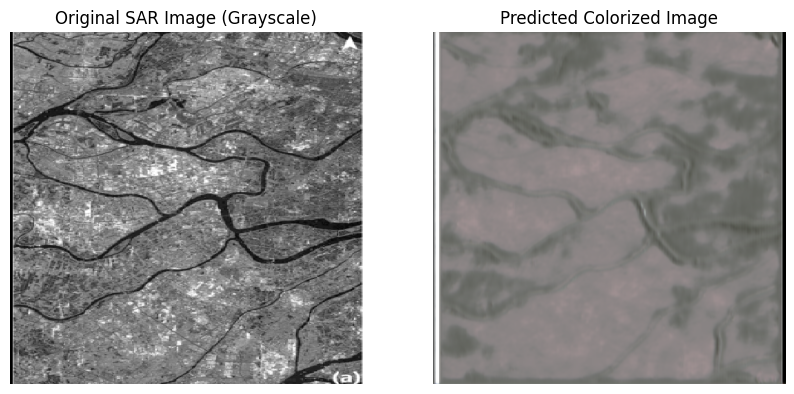

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Load a single image instead of directory
def load_single_image(image_path, img_size=(512, 512), is_grayscale=False):
    if is_grayscale:
        img = load_img(image_path, target_size=img_size, color_mode="grayscale")
    else:
        img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img)
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

# Preprocess the images (scaling, normalization)
def preprocess_images(sar_image, optical_image):
    sar_image = sar_image / 255.0  # Normalize to [0, 1]
    optical_image = optical_image / 255.0  # Normalize to [0, 1]
    return sar_image, optical_image

# Define paths for single SAR and optical images
sar_image_path = '/content/drive/MyDrive/data/SAR.png'        # Update with actual path
optical_image_path = '/content/drive/MyDrive/data/Optical.png' # Update with actual path

# Load single SAR and optical images
sar_image = load_single_image(sar_image_path, is_grayscale=True)
optical_image = load_single_image(optical_image_path)

# Preprocess the images
sar_image_processed, optical_image_processed = preprocess_images(sar_image, optical_image)

# Split data into training and testing sets
X_train, X_test = sar_image_processed, sar_image_processed  # Only one image
y_train, y_test = optical_image_processed, optical_image_processed

# Data Augmentation (optional)
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True)

image_datagen = ImageDataGenerator(**data_gen_args)
image_datagen.fit(X_train)

# Train the model (Replace 'model' with your actual deep learning model)
history = model.fit(X_train, y_train, epochs=30, batch_size=10, validation_data=(X_test, y_test))

# Predict the colorized image from the SAR image
predicted_colorized_image = model.predict(X_test)

# Postprocess the output (rescale from [0, 1] to [0, 255])
predicted_colorized_image = predicted_colorized_image * 255.0
predicted_colorized_image = np.clip(predicted_colorized_image[0], 0, 255).astype(np.uint8)  # Remove batch dimension and convert to uint8

# Display the colorized output
plt.figure(figsize=(10, 5))

# Show the original SAR image (grayscale)
plt.subplot(1, 2, 1)
plt.imshow(sar_image[0].reshape(512, 512), cmap='gray')  # Assuming 512x512 SAR image
plt.title("Original SAR Image (Grayscale)")
plt.axis('off')

# Show the colorized prediction
plt.subplot(1, 2, 2)
plt.imshow(predicted_colorized_image)
plt.title("Predicted Colorized Image")
plt.axis('off')

plt.show()


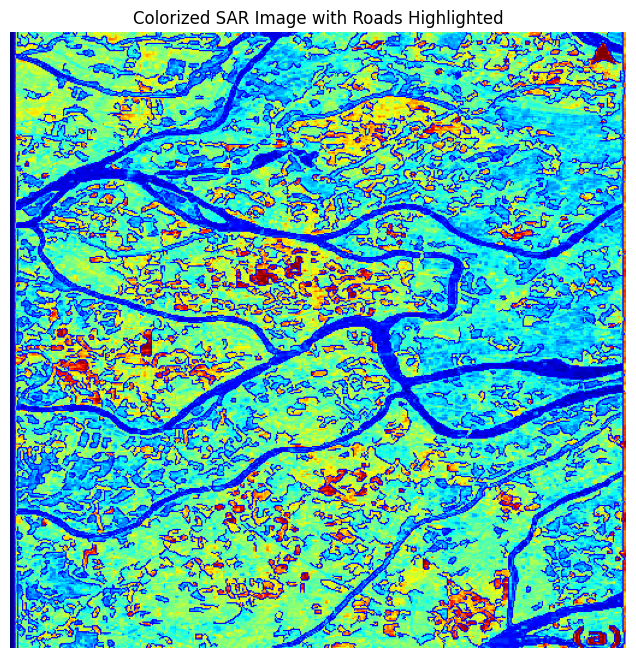

In [ ]:
import cv2
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from matplotlib import pyplot as plt

# Load and preprocess SAR image
def load_single_image(image_path, img_size=(512, 512), is_grayscale=False):
    img = load_img(image_path, target_size=img_size, color_mode="grayscale")
    img_array = img_to_array(img)
    return img_array

# Edge detection function for road extraction
def detect_edges(image):
    # Convert the image to 8-bit unsigned integer format
    if image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

    # Perform edge detection using Canny
    edges = cv2.Canny(blurred_image, threshold1=50, threshold2=150)

    return edges

# Colorize SAR image
def colorize_sar_image(sar_image):
    # Convert the grayscale SAR image to RGB (simple color mapping for now)
    colored_image = cv2.applyColorMap(sar_image.astype(np.uint8), cv2.COLORMAP_JET)

    return colored_image

# Highlight the edges (roads) on the colorized image
def highlight_edges_on_color_image(color_image, edges):
    # Convert edges to 3-channel to overlay on RGB image
    edges_colored = np.stack([edges] * 3, axis=-1)  # Shape becomes (512, 512, 3)

    # Color the edges white or a specific color
    color_image[edges > 0] = [255, 0, 0]  # Color the roads red

    return color_image

# Define the SAR image path
sar_image_path = '/content/drive/MyDrive/data/SAR.png'  # Update with actual path

# Load and preprocess the SAR image
sar_image = load_single_image(sar_image_path, is_grayscale=True)

# Resize the image to fit the model input if needed
sar_image_resized = cv2.resize(sar_image, (512, 512))

# Detect edges (roads)
edges = detect_edges(sar_image_resized)

# Colorize the SAR image
colorized_sar_image = colorize_sar_image(sar_image_resized)

# Highlight the edges (roads) on the colorized SAR image
output_image = highlight_edges_on_color_image(colorized_sar_image, edges)

# Display the final output image
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
plt.axis('off')
plt.title('Colorized SAR Image with Roads Highlighted')
plt.show()


1/1 [==============================] - 0s 80ms/step - loss: 0.0253 - accuracy: 0.5682
Test Loss: 0.02527141571044922, Test Accuracy: 0.5681610107421875
1/1 [==============================] - 0s 17ms/step


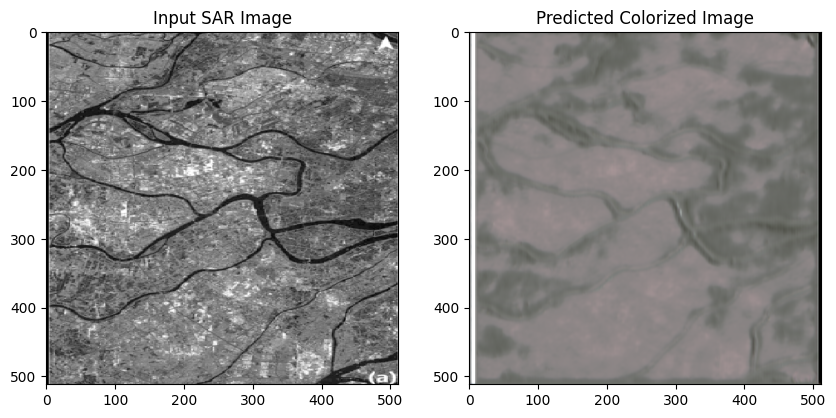

In [ ]:

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Generate a colorized image
predicted_image = model.predict(X_test[:1])[0]
plt.figure(figsize=(10, 5))

# Display SAR Input
plt.subplot(1, 2, 1)
plt.imshow(X_test[0].squeeze(), cmap='gray')
plt.title('Input SAR Image')

# Display Colorized Output
plt.subplot(1, 2, 2)
plt.imshow(predicted_image)
plt.title('Predicted Colorized Image')
plt.show()
